## Settings

In [1]:
import os
import sys
from sys import platform
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config

In [2]:
_config = get_global_config()
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH_SHARED'))
if platform == 'win32':
	RESULTS_PATH = RESULTS_PATH.replace('/', '\\')
EMISSIONS_FILE = 'emissions.csv'
METRICS_FILE = 'metrics.csv'
PARAMS_FILE = 'params.csv'

In [3]:
def get_outcome(dataset, models, machine='azure'):
	experiments = []
	for m in next(os.walk(RESULTS_PATH + dataset))[1]:
		if m in models:
			e = pd.read_csv(os.path.join(RESULTS_PATH, dataset, m, EMISSIONS_FILE))
			if len(e[e['os'].str.contains(machine)]):
				experiments.append(os.path.join(dataset, m))
	experiments = sorted(experiments)

	metrics_list = ['recall@10', 'mrr@10', 'ndcg@10', 'hit@10', 'map@10', 'precision@10', 'gauc', 'itemcoverage@10', 'averagepopularity@10', 'giniindex@10', 'shannonentropy@10']

	results = {'emissions': [], 'duration': [], 'cpu_power': [], 'gpu_power': [], 'ram_power': []}
	metrics = {}
	for m in metrics_list:
		metrics[m] = []

	for _, v in enumerate(experiments):
		e = pd.read_csv(os.path.join(RESULTS_PATH, v, EMISSIONS_FILE))
		m = pd.read_csv(os.path.join(RESULTS_PATH, v, METRICS_FILE))
		e = e[e['os'].str.contains(machine)]
		m = m[m['run_id'] == e.iloc[0]['run_id']]
		for k in results.keys():
			if k == 'emissions':
				results[k].append(e.iloc[0][k]*1000)
			else:
				results[k].append(e.iloc[0][k])
		for k in metrics.keys():
			metrics[k].append(m.iloc[0][k])

	return results, metrics, experiments

In [4]:
def plot_results(results, metrics, experiments):
	counter = 0
	l = [
		['emissions','recall@10'],['emissions','ndcg@10'],['emissions','averagepopularity@10'],['emissions','giniindex@10']
	]

	fig, axs = plt.subplots(2, 2, figsize=(18, 12))
	for _, axl in enumerate(axs):
		for _, ax in enumerate(axl):
			ax.scatter(results[l[counter][0]], metrics[l[counter][1]], s=80)
			ax.set_title(l[counter][0]+' X '+l[counter][1], fontsize=18)
			ax.set_xlabel(l[counter][0] + ' (g, log base2)', fontsize=14)
			ax.set_ylabel(l[counter][1] + ' (%)', fontsize=14)
			ax.grid()
			for i, (xi, yi) in enumerate(zip(results[l[counter][0]], metrics[l[counter][1]])):
				ax.text(xi, yi, experiments[i].split('/')[1], fontsize=14)
			ax.set_xscale('log', base=2)
			counter = counter + 1
	fig.tight_layout()
	plt.show()

def plot_power(results, experiments):
	labels_x1 = [l.split('/')[1] for l in experiments]
	features_to_plot1 = {'CPU': results['cpu_power'], 'GPU': results['gpu_power'], 'RAM': results['ram_power']}

	x1 = np.arange(len(labels_x1))  # the label locations
	width = 0.2  # the width of the bars
	multiplier = 0

	fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))

	for attribute, measurement in features_to_plot1.items():
		offset = width * multiplier
		rects = ax1.bar(x1 + offset, [round(i, 2) for i in measurement], width, label = attribute)
		ax1.bar_label(rects, padding = 3)
		multiplier += 1
	ax1.set_xlabel('Models', fontsize=14)
	ax1.set_ylabel('Power (W)', fontsize=14)
	ax1.set_title('Power consuption by component', fontsize=18)
	ax1.set_xticks(x1 + (width), labels_x1)
	ax1.legend(loc = 'upper right', ncol = 2)

	fig.tight_layout()
	plt.show()

## Movielens

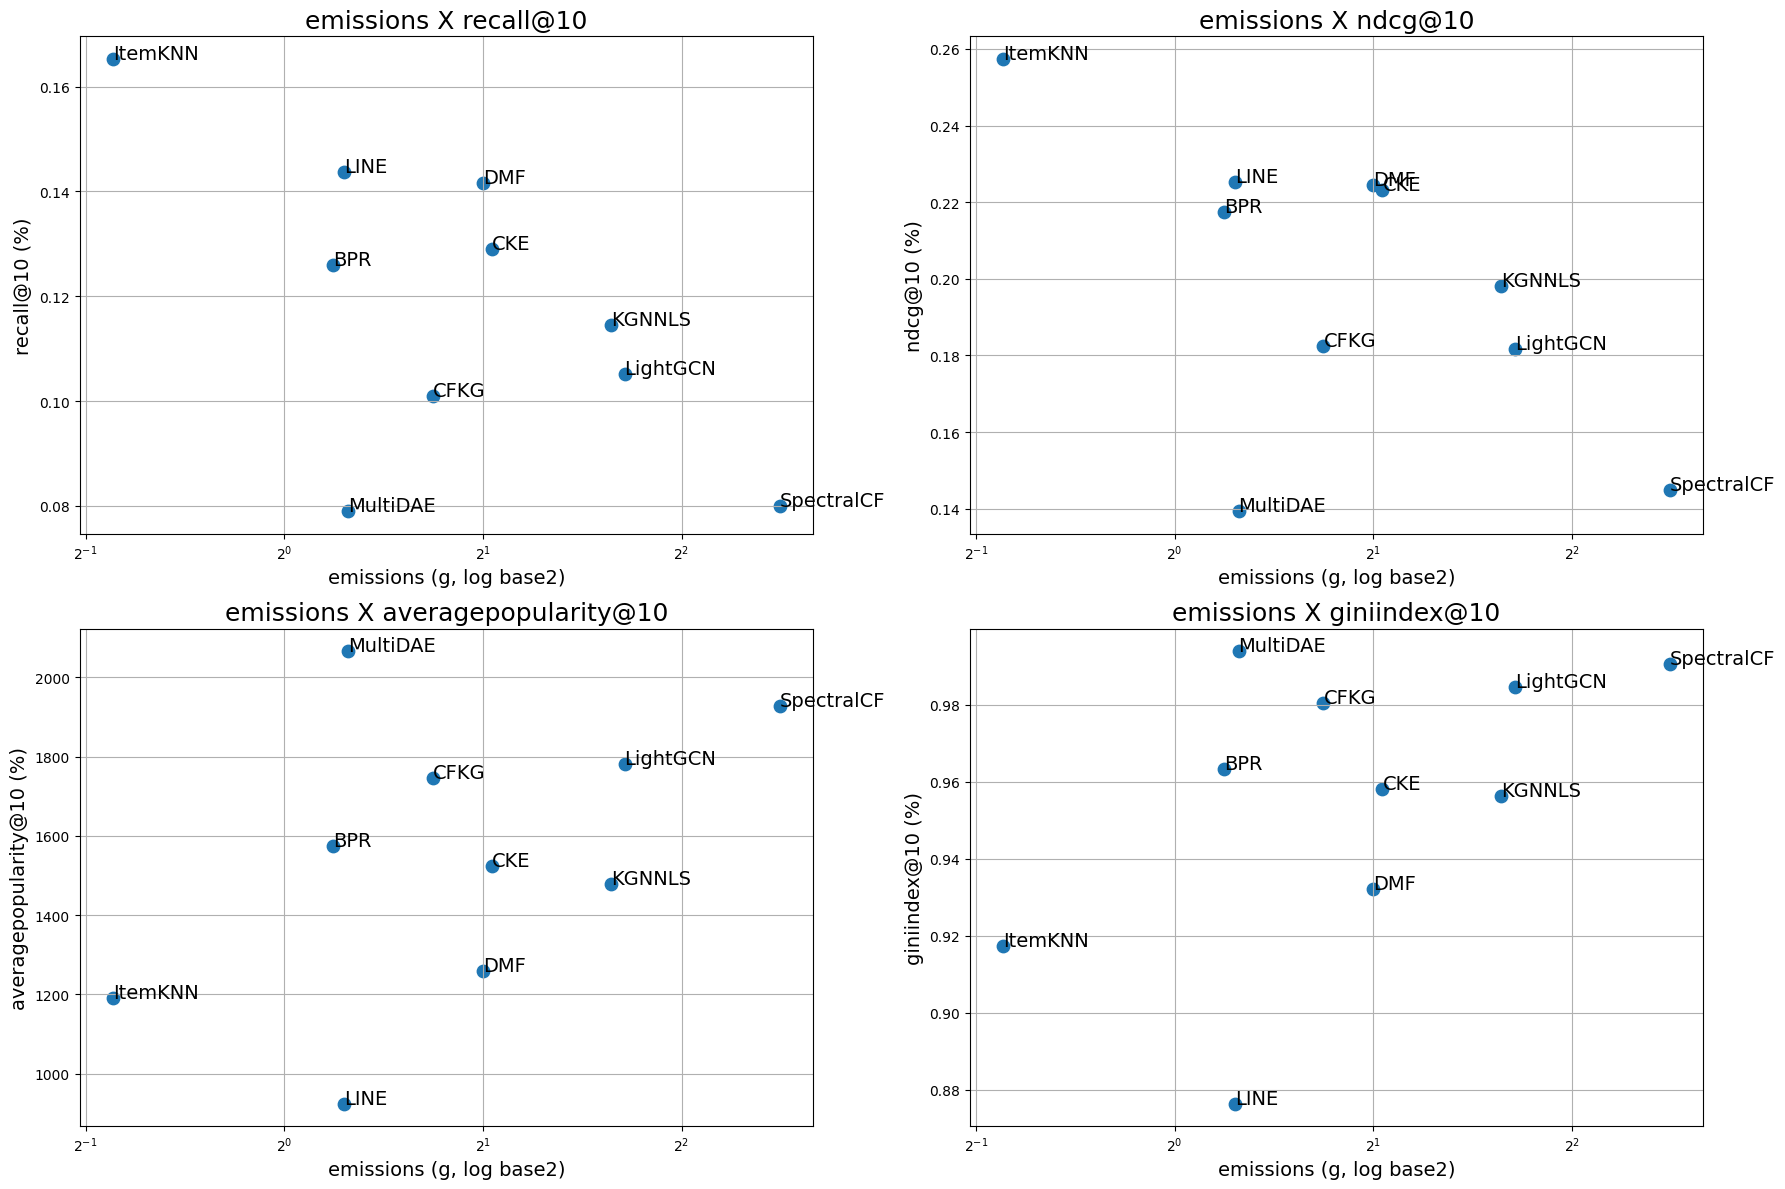

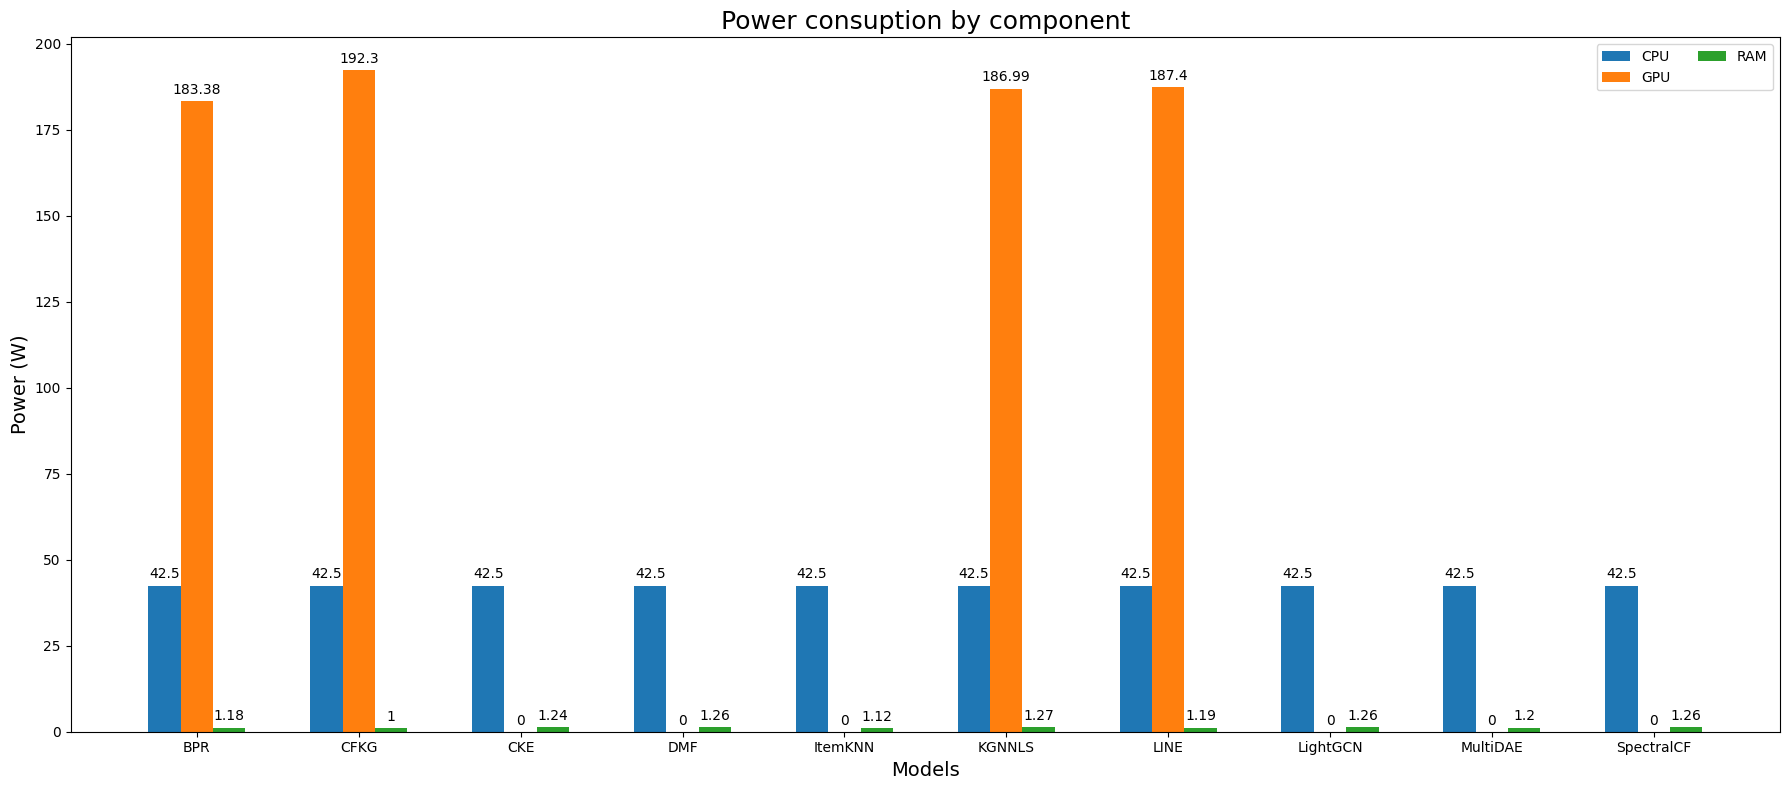

In [5]:
models = ['BPR', 'CFKG', 'CKE', 'DMF', 'ItemKNN', 'KGNNLS', 'LINE', 'LightGCN', 'MultiDAE', 'SpectralCF']
results, metrics, experiments = get_outcome(dataset='movielens_1m', models=models)
plot_results(results, metrics, experiments)
plot_power(results, experiments)

## Mind

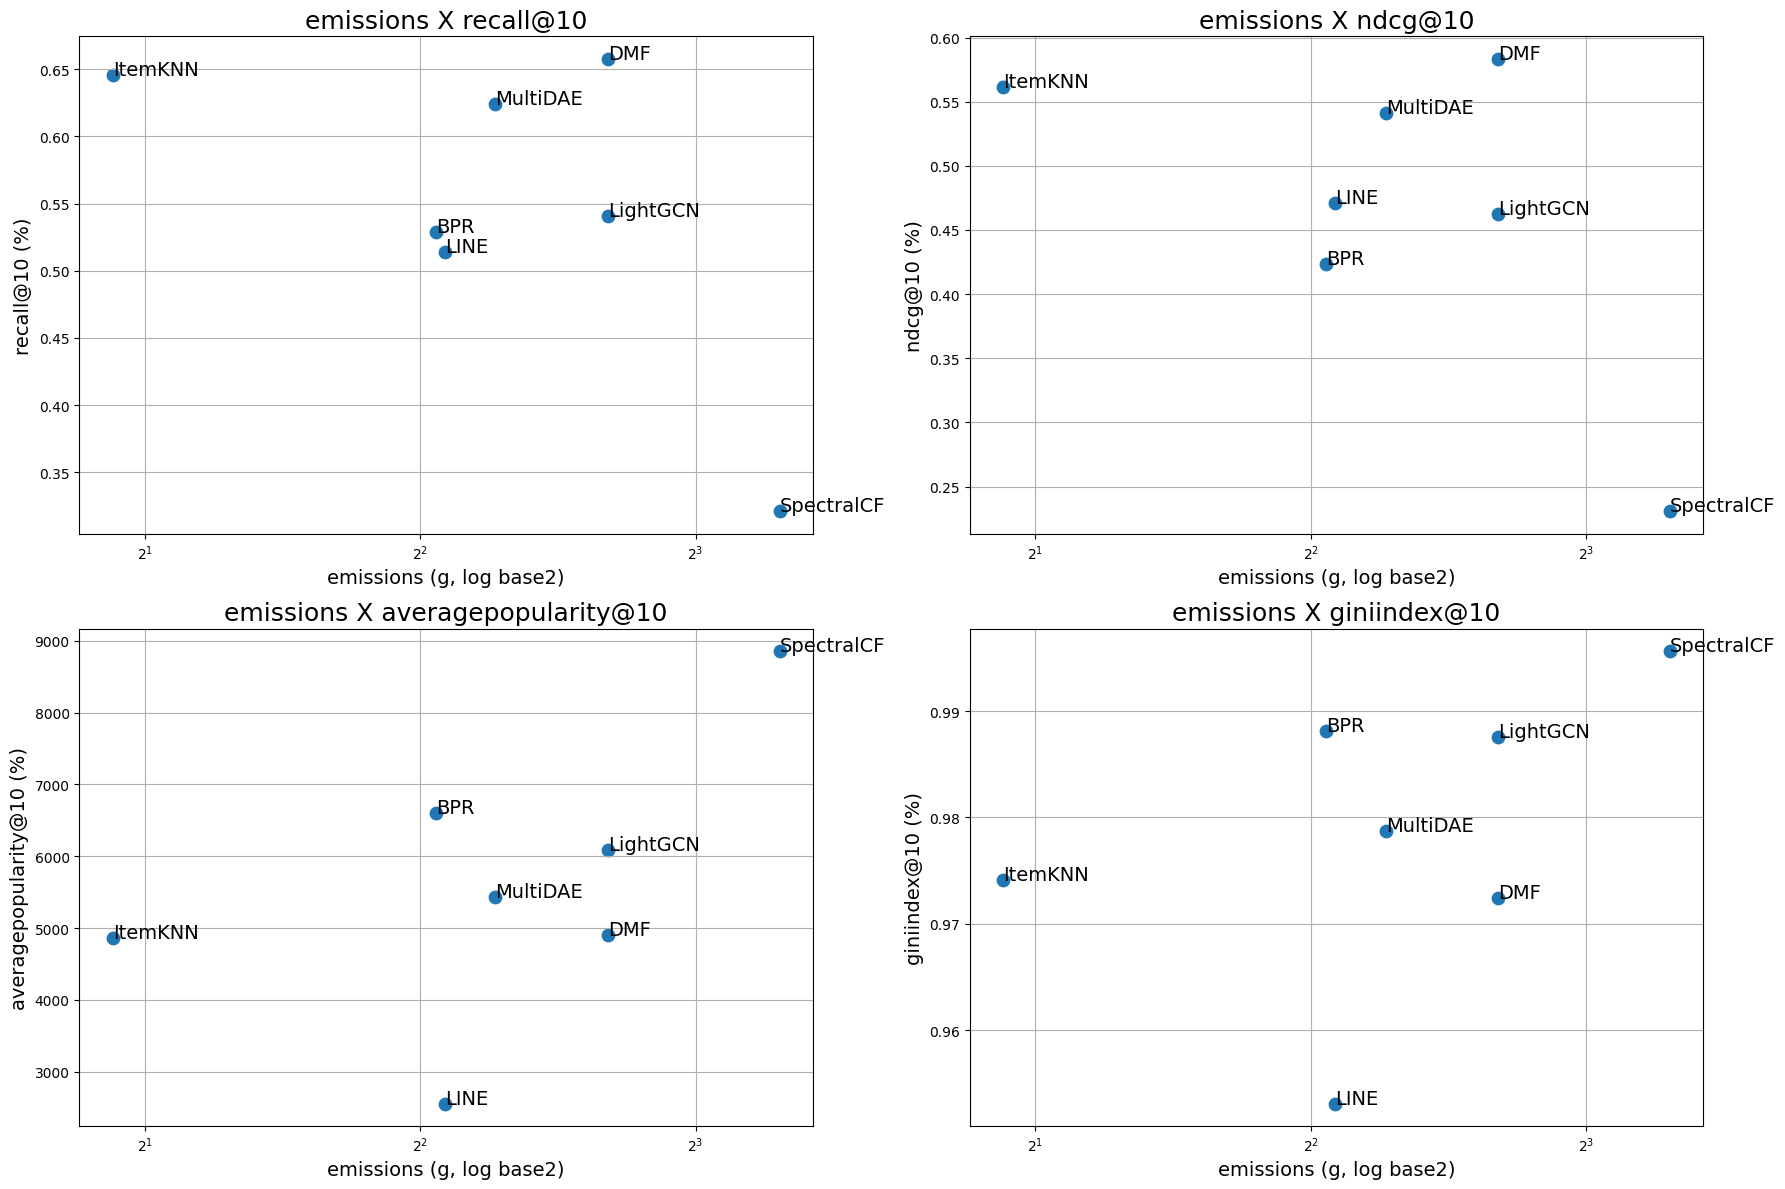

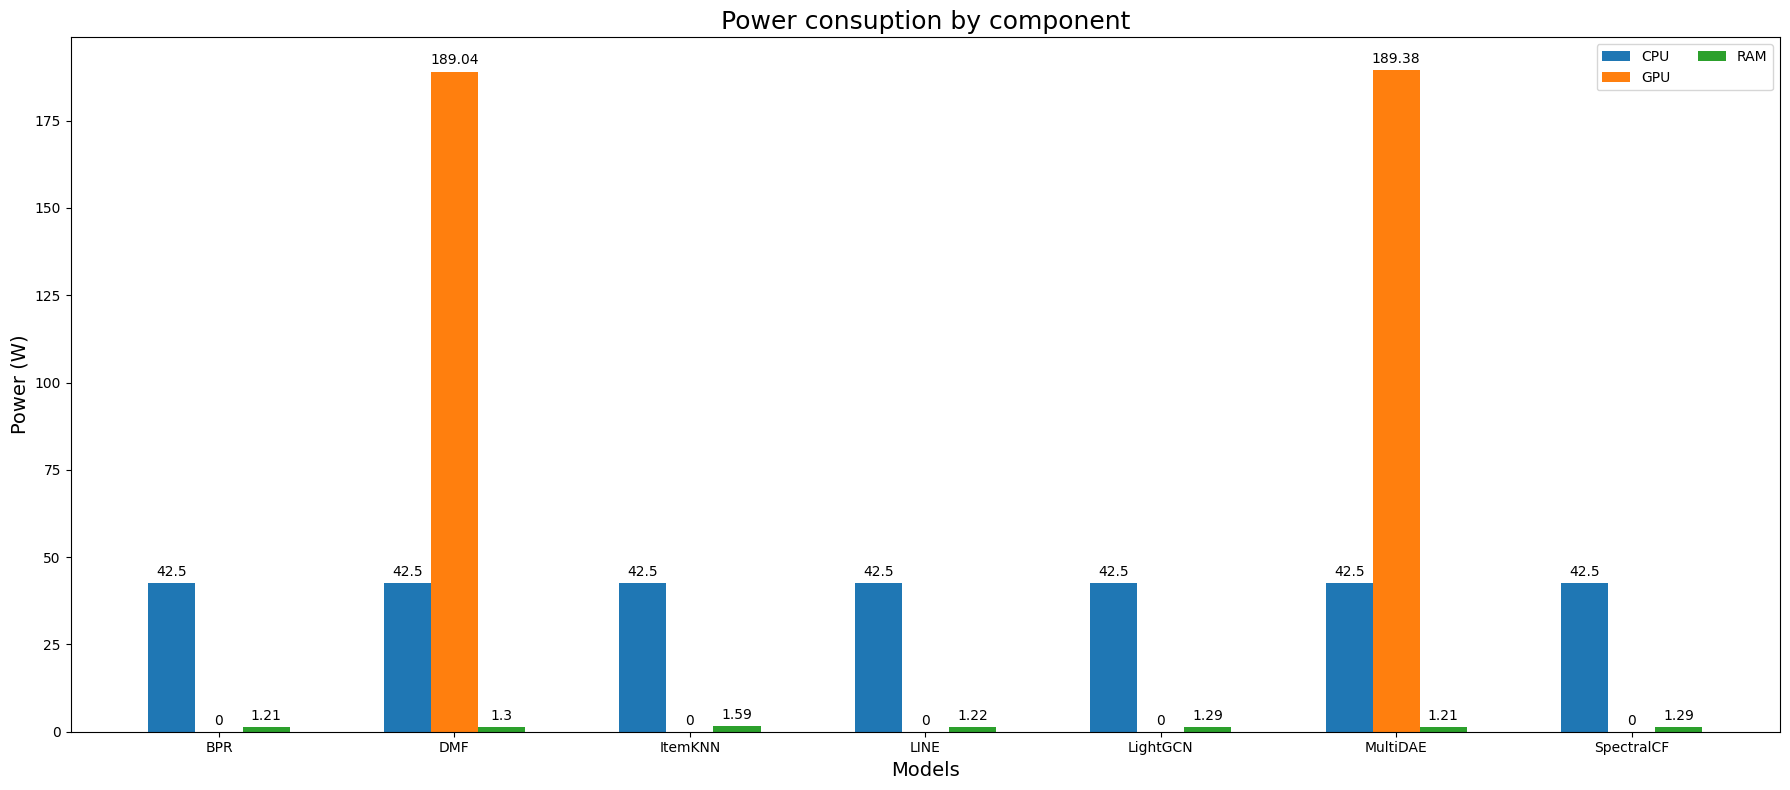

In [6]:
results, metrics, experiments = get_outcome(dataset='mind', models=models)
plot_results(results, metrics, experiments)
plot_power(results, experiments)

## Amazon Books

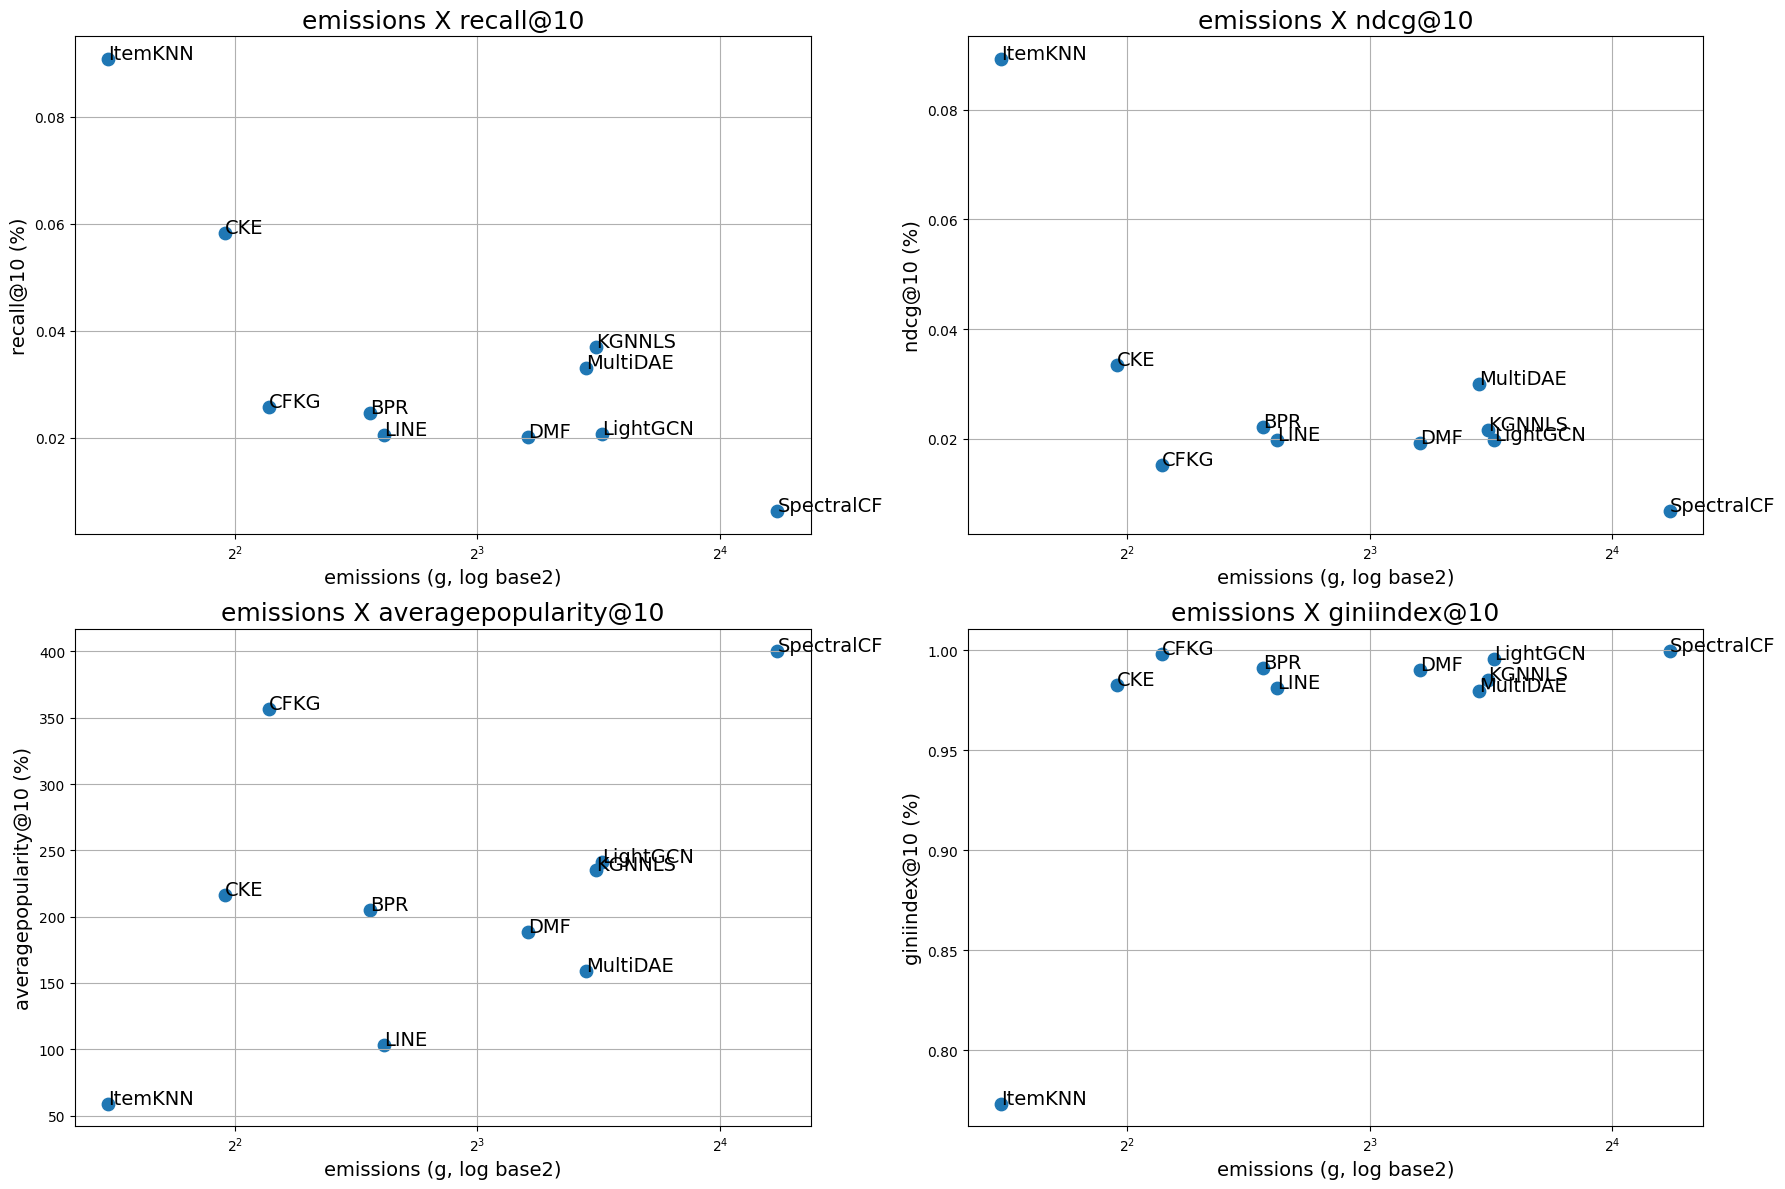

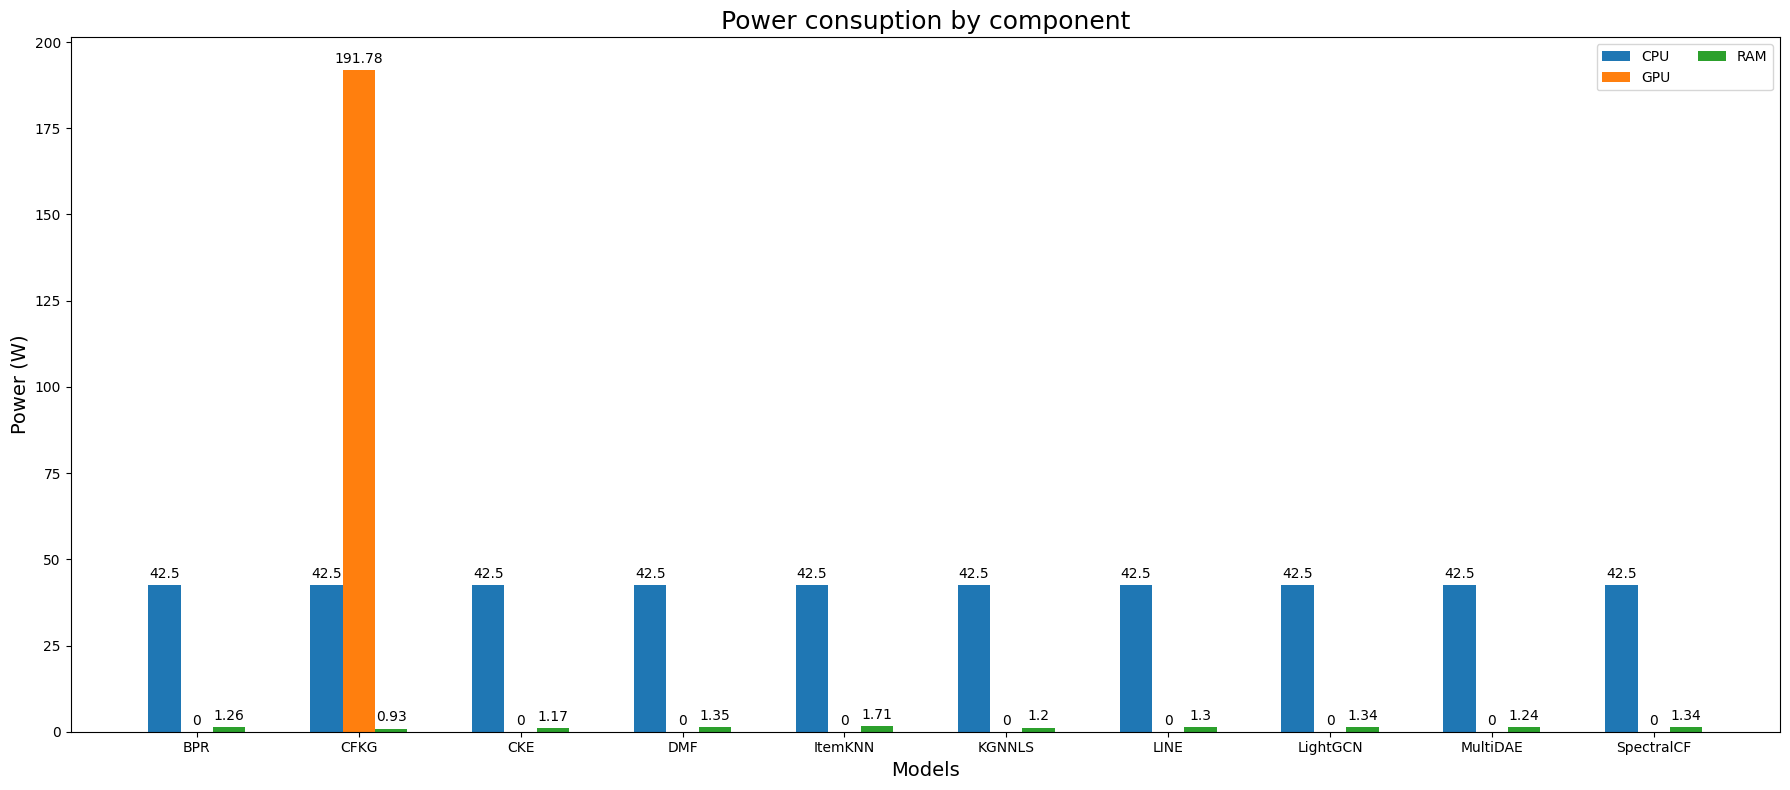

In [7]:
results, metrics, experiments = get_outcome(dataset='amazon_books_60core_kg', models=models)
plot_results(results, metrics, experiments)
plot_power(results, experiments)